In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee as mc
from scipy import stats

%matplotlib inline

In [2]:
def createMockCluster(rin,rout,nmean,k,smax,m,vmean,threeD=False):
    ntot = np.random.poisson(lam=nmean)
    
    nu0 = ntot/(4*np.pi*(np.log(rout/rin))) if k==3. else ntot*(3.-k)/(4*np.pi*(rout**(3.-k)-rin**(3.-k)))
    #rho = 4*np.pi*nu0*np.random.uniform(low=rin,high=rout,size=ntot)**(2.-k)
    rho = np.power(np.random.uniform(4*np.pi*nu0*rin**(2.-k),4*np.pi*nu0*rout**(2.-k),size=ntot)/(4*np.pi*nu0),1./(2-k))
    phi = np.random.uniform(0.,2*np.pi,ntot)
    theta = np.arccos(np.random.uniform(-1,1,ntot))
    
    x = rho*np.sin(theta)*np.cos(phi)
    y = rho*np.sin(theta)*np.sin(phi)
    
    vobs = np.array([np.random.normal(loc=0.,scale=(1/np.sqrt(3))*smax/(i**m))+vmean for i in rho])
    
    if threeD:
        z = rho*np.cos(theta)
        return pd.DataFrame(np.hstack((x.reshape((ntot,1)),y.reshape((ntot,1)),z.reshape((ntot,1)),\
                                      vobs.reshape((ntot,1)),rho.reshape((ntot,1)))),columns=['x','y','z','vobs','rho'])
    else:
        r = np.sqrt(np.power(x,2.)+np.power(y,2.))
        return pd.DataFrame(np.hstack((r.reshape((ntot,1)),vobs.reshape((ntot,1)))),columns=['r','vobs'])

In [3]:
#load data

data=pd.read_csv('continuousMock5.csv')
#data.rename(columns={'Unnamed: 0':'id','0':'origAnn','1':'x','2':'y','3':'z','4':'vobs'},inplace=True)
#
#data['r'] = np.power(np.power(data['x'],2.)+np.power(data['y'],2.),0.5)

def defineAnnuli(r,nAnn):
    return np.append(0.,np.sort(r)[np.linspace(0,len(r)-1,nAnn).astype(int)][1:])

nAnn = 10
annuli = defineAnnuli(data['r'],nAnn)

print annuli

[   0.            0.95736622    1.20732841    1.57089614    2.17402307
    3.21106781    5.90959364   11.07235251   33.2303394   755.40312831]


In [4]:
def labelGalaxies(data,annuli):
    #adds a column to data indicating the galaxy's membership in an annulus
    bla = np.zeros(len(data['r']))
    for i in range(len(annuli)-1):
        bla += i*np.array(np.logical_and(data['r']>annuli[i],data['r']<=annuli[i+1]).astype(int))
    return bla

def galInAnn(data,annuli):
    #calculates the number of galaxies in all the annuli
    return np.array([(data['annuli']==i).sum() for i in range(len(annuli)-1)])

def sigInAnn(data,annuli):
    return [np.std(data['vobs'][data['annuli']==i],ddof=1) for i in range(len(annuli)-1)]

def getProfiles(annuli,rin,rout,nmean,k,smax,m,vmean):
    mock = createMockCluster(rin,rout,nmean,k,smax,m,vmean)
    mock['annuli'] = labelGalaxies(mock,annuli)
    return galInAnn(mock,annuli),sigInAnn(mock,annuli)

In [5]:
data['annuli'] = labelGalaxies(data,annuli)

nObs = galInAnn(data,annuli)
sObs = sigInAnn(data,annuli)

vMean = np.mean(data['vobs'])

print nObs,sObs

[112 111 111 111 111 111 111 111 111] [1531.9828886951695, 1512.731745345587, 1311.3786694314058, 1017.1638266071807, 1008.78546367375, 756.1698132039214, 578.9581236078482, 389.46051704842796, 177.43934802582393]


In [6]:
#all log likelihoods

#make a table of log(n!)-s for n=1,...
#factorialTable = np.cumsum(np.append(0,[np.log(i) for i in range(1,len(data['r']))]))

def logPriorK(k):
    #starting gaussian
    #nu0 = 3. #mean prior density index
    #sigma = 1.
    return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorM(m):
    #starting gaussian
    #nu0 = -.2 #mean prior sigma index
    #sigma = 0.1
    return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorSigma0(sigma0):
    #starting gaussian
    #nu0 = 1000 #mean prior sigma index
    #sigma = 500
    if sigma0<10.:
        return -1e20
    else:
        return 0.0
    #return -0.5*np.log(2*np.pi*sigma**2)-0.5*(k-nu0)**2/(2*sigma**2)

def logPriorNmean(nmean):
    if nmean<0.: 
        return -1e20
    else:
        return 0.0

def logPriorVmean(vmean):
    return 0.0

def logLikelihoodNu(prediction,data):
    return np.sum(data*np.log(prediction)-prediction)

def logLikelihoodSigma(vObs,vPred,nObs):
    # distribution of variances is chisq, as shown, for example, at
    # https://onlinecourses.science.psu.edu/stat414/node/174
    return np.sum(np.log(stats.chi2.pdf((nObs-1.)*np.power(vObs,2.)/np.power(vPred,2.),nObs-1)))

def logPosterior(params,annuli,rin,rout,nObs,sObs):
    nmean,k,smax,m,vmean = params
    if nmean<0. or smax<0.: return -np.inf
    nPred,sPred = getProfiles(annuli,rin,rout,50*nmean,k,smax,m,vmean)
    if not np.all(nPred>=3.): return -np.inf
    nPred/=50
    return logPriorK(k)+logPriorM(m)+logPriorSigma0(smax)+logPriorNmean(nmean)+logPriorVmean(vmean)+\
           logLikelihoodNu(nPred,nObs)+logLikelihoodSigma(sObs,sPred,nObs)

In [7]:
nmean,k,smax,m,vmean=[1.30539316e+03,1.19789549e+00,1.36928408e+03,1.91498109e-01,-1.73709495e+02]
#print logPosterior(pars,annuli,1,1000,nObs,sObs)

nPred,sPred = getProfiles(annuli,1,1000,50*1.30539316e+03,1.19789549e+00,1.36928408e+03,1.91498109e-01,-1.73709495e+02)
nPred/=50.
print nPred,sPred
#print nPred,sPred
print logLikelihoodSigma(sObs,sPred,nObs)#+logLikelihoodNu(nPred,nObs)+0.+0.+0.+0.

[ 126    1    1    3    5   11   18   69 1064] [228.12101661941708, 680.8924171208203, 667.7215023256065, 681.3533537913917, 612.9542669263154, 544.1680530501917, 477.0897772296591, 401.4338857653523, 264.4595034789899]
-inf


/home/ondrej/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Implicitly casting between incompatible kinds. In a future numpy release, this will raise an error. Use casting="unsafe" if this is intentional.


In [8]:
ntot=1000
bla1,bla2 = getProfiles(annuli,1,1000,50*ntot,3,1000,0.2,0)

bla1/=50

print bla1
print bla2

[189 161 149 137 115 110  60  48  23]
[545.0544351359463, 544.8733686887554, 517.0017723005869, 486.1635265696263, 463.91157105755144, 420.7070336573174, 373.24802612863886, 320.9820515576513, 236.474821245837]


In [9]:
nwalkers = 40
ndim = 5

#initial = np.tile(np.array([np.random.normal(1000,100),np.random.normal(3,0.3),np.random.normal(1000,100),np.random.normal(0.2,0.02)]),10).reshape((nwalkers,ndim))
initial = np.array([np.random.normal(1000,150),np.random.normal(3.,0.3),\
                    np.random.normal(1000,100),np.random.normal(0.2,0.03),\
                    np.random.normal(0,100)])

for i in range(nwalkers-1):
    initial=np.vstack((initial,np.array([np.random.normal(1000,150),np.random.normal(3.,0.3),\
                    np.random.normal(1000,100),np.random.normal(0.2,0.03),\
                                         np.random.normal(0,100)])))

#for i in range(nwalkers):
#    for j in range(ndim):
#        initial[i,j]+=np.random.normal()


In [10]:
rin = 1
rout = 1000
sampler = mc.EnsembleSampler(nwalkers, ndim, logPosterior, args=[annuli,rin,rout,nObs,sObs],threads=4)

#p0 = np.array([1000,3,1000,0.2])reshape((nwalkers,ndim))

#pos, prob, state = sampler.run_mcmc(initial, 5)


In [11]:
pos, prob, state = sampler.run_mcmc(initial, 20)
sampler.reset()

In [12]:
#sampler.reset()
for i in range(75):
    pos, prob, state = sampler.run_mcmc(pos, 5)
    print "Step "+str(50*(i+1))

Step 50
Step 100
Step 150
Step 200
Step 250
Step 300
Step 350
Step 400
Step 450
Step 500
Step 550
Step 600
Step 650
Step 700
Step 750
Step 800
Step 850
Step 900
Step 950
Step 1000
Step 1050
Step 1100
Step 1150
Step 1200
Step 1250
Step 1300
Step 1350
Step 1400
Step 1450
Step 1500
Step 1550
Step 1600
Step 1650
Step 1700
Step 1750
Step 1800
Step 1850
Step 1900
Step 1950
Step 2000
Step 2050
Step 2100
Step 2150
Step 2200
Step 2250
Step 2300
Step 2350
Step 2400
Step 2450
Step 2500
Step 2550
Step 2600
Step 2650
Step 2700
Step 2750
Step 2800
Step 2850
Step 2900
Step 2950
Step 3000
Step 3050
Step 3100
Step 3150
Step 3200
Step 3250
Step 3300
Step 3350
Step 3400
Step 3450
Step 3500
Step 3550
Step 3600
Step 3650
Step 3700
Step 3750


(15000, 5)


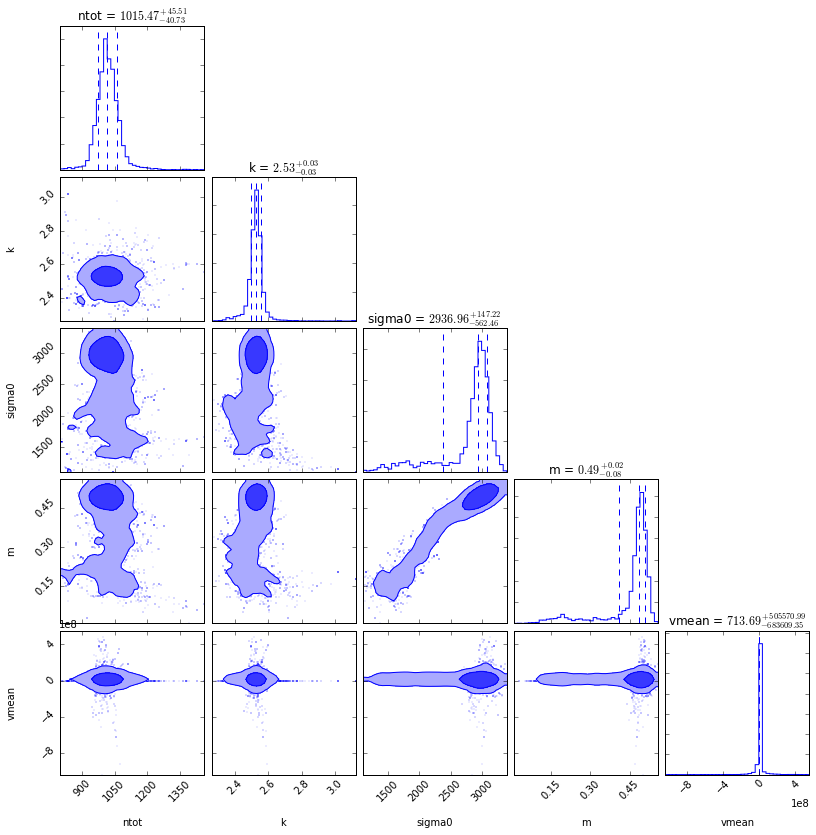

In [13]:
#chain = np.load('chain_conMock0_15000steps.npy')

print sampler.flatchain.shape

import corner
corner.corner(sampler.flatchain, labels=['ntot','k','sigma0','m','vmean'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=40, 
                smooth=1.0);
plt.show()

In [ ]:
chain = np.load('chain_virgoDataMembers_10500steps.npy')

#print sampler.flatchain.shape

import corner
corner.corner(chain, labels=['ntot','k','sigma0','m','vmean'],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=40, smooth=1.0);
plt.show()

In [ ]:
radii = np.logspace(0,3,20)

def generateMassProfile(radii,sigma0,m,k):
    return -radii*(sigma0*radii**(-m))**2*(-k-2*m)

for i in sampler.flatchain[14000:]:
    plt.plot(radii,generateMassProfile(radii,i[2],i[3],i[1]),alpha=0.01)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('radius')
plt.ylabel('mass (arb.units)')
    

In [14]:
np.save('chain_continuousMock5_15000steps.npy',sampler.flatchain)